<a href="https://colab.research.google.com/github/Code-acus/ASP_NET_Student_Lab_PartyInvites/blob/main/Sentiment%20Analysis%20Using%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Imports
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
# Mount your Drive
drive.mount('/content/drive')

# Define the folder where your raw files live
RAW_DATA_DIR = '/content/drive/MyDrive/D604 Data/sentiment labelled sentences'

# Define each of the five output folders as its own top-level folder
PLOTS_DIR          = '/content/drive/MyDrive/D604 Data/sentiment_plots'
HTML_OUTPUT_DIR    = '/content/drive/MyDrive/D604 Data/sentiment_html_output'
MODELS_DIR         = '/content/drive/MyDrive/D604 Data/sentiment_models'
OUTPUT_DIR         = '/content/drive/MyDrive/D604 Data/sentiment_output'
PROCESSED_DATA_DIR = '/content/drive/MyDrive/D604 Data/sentiment_processed_data'

# Create them if they don't exist
for path in [
    PLOTS_DIR,
    HTML_OUTPUT_DIR,
    MODELS_DIR,
    OUTPUT_DIR,
    PROCESSED_DATA_DIR
]:
    os.makedirs(path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Core parameters
for path in [
    RAW_DATA_DIR,
    PLOTS_DIR,
    HTML_OUTPUT_DIR,
    MODELS_DIR,
    OUTPUT_DIR,
    PROCESSED_DATA_DIR
]:
    os.makedirs(path, exist_ok=True)

In [51]:
# Core parameters
text_col = 'text'
sentiment_col = 'sentiment'
vocabulary_size = 10000
max_length = 100
embedding_dim = 16

In [47]:
# Load & combine the three labeled-sentences files
amazon = pd.read_csv(
    os.path.join(RAW_DATA_DIR, 'amazon_cells_labelled.txt'),
    sep='\t', header=None, names=[text_col, sent_col]
)
imdb = pd.read_csv(
    os.path.join(RAW_DATA_DIR, 'imdb_labelled.txt'),
    sep='\t', header=None, names=[text_col, sent_col]
)
yelp = pd.read_csv(
    os.path.join(RAW_DATA_DIR, 'yelp_labelled.txt'),
    sep='\t', header=None, names=[text_col, sent_col]
)
data = pd.concat([amazon, imdb, yelp], ignore_index=True)

# save the raw combined dataset
data.to_csv(
    os.path.join(PROCESSED_DATA_DIR, 'raw_combined.csv'),
    index=False
)

In [48]:
# Exploratory data analysis (EDA) and summary statistics

# Missing labels
missing = data[sent_col].isna().sum()

# Distribution
positive_count = int(data[sent_col].sum())
negative_count = int((data[sent_col] == 0).sum())

# Text length and word count (make sure you've already computed these columns)
data['text_length_chars'] = data[text_col].str.len()
data['word_count']        = data[text_col].str.split().map(len)

# EDA summary dict
eda_stats = {
    'missing_labels': missing,
    'positive_count': positive_count,
    'negative_count': negative_count,
    'average_chars': data['text_length_chars'].mean(),
    'average_words': data['word_count'].mean(),
}

# Save the one‐row summary
pd.DataFrame.from_dict(
    eda_stats,
    orient='index',
    columns=['value']
).to_csv(
    os.path.join(OUTPUT_DIR, 'eda_stats.csv')
)

# Save full describe() on lengths and counts
data[['text_length_chars', 'word_count']].describe().to_csv(
    os.path.join(OUTPUT_DIR, 'eda_describe.csv')
)

# Print the results and save
print(pd.DataFrame(eda_stats, index=[0]))
pd.DataFrame(eda_stats, index=[0]).to_csv(
    os.path.join(OUTPUT_DIR, 'eda_stats.csv')
)
print(data[['text_length_chars', 'word_count']].describe())
data[['text_length_chars', 'word_count']].describe().to_csv(
    os.path.join(OUTPUT_DIR, 'eda_describe.csv')
)

print("Eda output has been saved to:")
print(os.path.join(OUTPUT_DIR, 'eda_stats.csv'))
print(os.path.join(OUTPUT_DIR, 'eda_describe.csv'))


   missing_labels  positive_count  negative_count  average_chars  \
0               0            1386            1362      71.528384   

   average_words  
0       13.00655  
       text_length_chars  word_count
count        2748.000000  2748.00000
mean           71.528384    13.00655
std           201.987266    35.81939
min             7.000000     1.00000
25%            32.000000     6.00000
50%            55.000000    10.00000
75%            87.000000    16.00000
max          7944.000000  1390.00000
Eda output has been saved to:
/content/drive/MyDrive/D604 Data/sentiment_output/eda_stats.csv
/content/drive/MyDrive/D604 Data/sentiment_output/eda_describe.csv


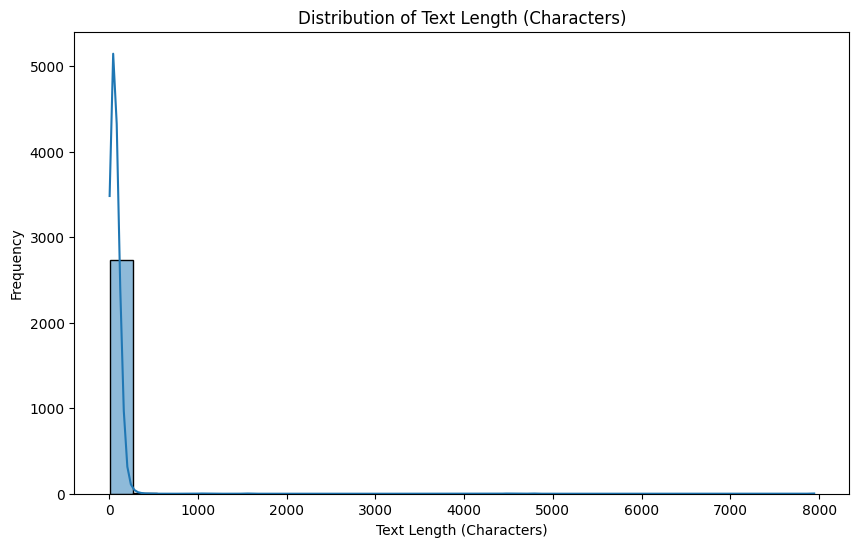

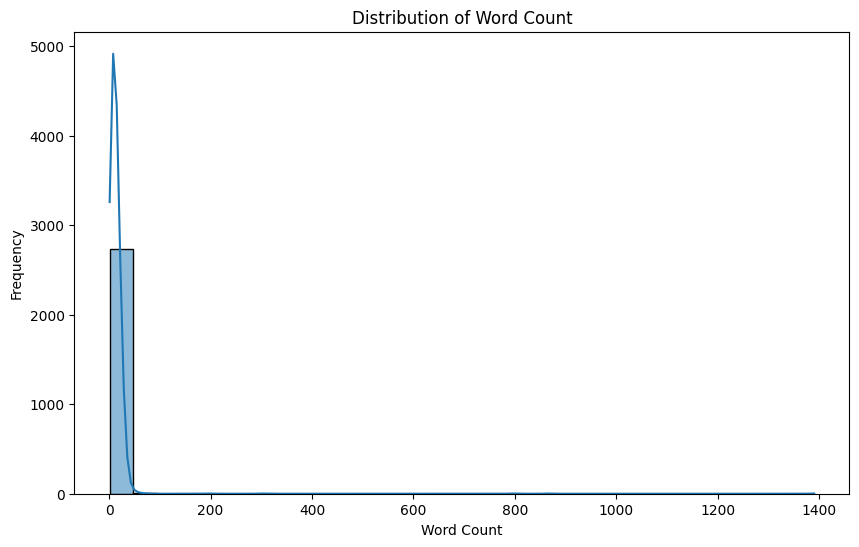

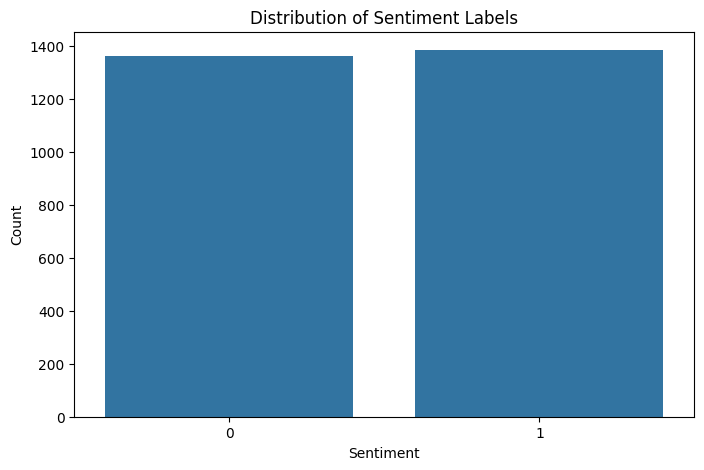

In [49]:
# Plot the distributions

# Text‐length histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length_chars'], bins=30, kde=True)
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.savefig(os.path.join(PLOTS_DIR, 'text_length_hist.png'))
plt.show()

# Word‐count histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig(os.path.join(PLOTS_DIR, 'word_count_hist.png'))
plt.show()

# Sentiment‐label count
plt.figure(figsize=(8, 5))
sns.countplot(x=sent_col, data=data)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig(os.path.join(PLOTS_DIR, 'sentiment_count.png'))
plt.show()

In [52]:
# Preprocess, clean and tokenize that data

# Data cleansing
data[text_col] = (
    data[text_col]
    .str.lower()
    .str.replace(r'[“”]', '"', regex=True)
    .str.replace(r"[^a-z0-9\s\.,!\?']", '', regex=True)
)

# Tokenizer — use the same vocab_size you set earlier
tokenizer = Tokenizer(
    num_words=vocabulary_size,
    oov_token='<OOV>',
    filters='''!"#$%&()*+/:;<=>?@[\\]^_`{|}~\t\n'''
)
tokenizer.fit_on_texts(data[text_col])
word_index = tokenizer.word_index
actual_vocab = len(word_index) + 1
print(f'Found {actual_vocab} unique tokens.')

# Save tokenizer vocab
pd.DataFrame(
    list(word_index.items()),
    columns=['word', 'index']
).query(
    'index <= @vocabulary_size'
).to_csv(
    os.path.join(PROCESSED_DATA_DIR, 'tokenizer_vocab.csv'),
    index=False
)

# Sequences and padding — use max_length
sequences = tokenizer.texts_to_sequences(data[text_col])
padded_sequences = pad_sequences(
    sequences,
    maxlen=max_length,     # <- your defined variable
    padding='post',
    truncating='post'
)

# Save the full padded array (if you like)
pd.DataFrame(padded_sequences).to_csv(
    os.path.join(PROCESSED_DATA_DIR, 'padded_sequences.csv'),
    index=False
)

# Print a sample padded sequence
print(padded_sequences[:1])

Found 6895 unique tokens.
[[  27   49    6   56  130   13   90    7  330   11   12   78   12    2
   210  604    4   73   60    5 2466    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
